<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_09/02_01_transfer_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Imports and Setup

In [1]:
# Step 1: Imports and Setup
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Enable GPU memory growth if needed
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)


##  Step 2: Load Cats vs Dogs Dataset

In [2]:
(train_ds, val_ds), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

IMG_SIZE = 224
BATCH_SIZE = 32

# Preprocessing pipeline
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image / 255.0, label

train_ds = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.SMAGY5_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


##  Step 3: Feature Extraction with MobileNetV2 (Frozen Base)

In [3]:
# Load base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze base

# Create model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train only the classification head
history = model.fit(train_ds, validation_data=val_ds, epochs=5)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 70s 101ms/step - accuracy: 0.9426 - loss: 0.1442 - val_accuracy: 0.9837 - val_loss: 0.0438
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.9848 - loss: 0.0445 - val_accuracy: 0.9845 - val_loss: 0.0418
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.9867 - loss: 0.0389 - val_accuracy: 0.9850 - val_loss: 0.0411
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step - accuracy: 0.9886 - loss: 0.0356 - val_accuracy: 0.9856 - val_loss: 0.0409
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.9901 - loss: 0.0330 - val_accuracy: 0.9856 - val_loss: 0.0413


## Step 4: Fine-Tuning the Top Layers

In [4]:
# Unfreeze top layers of base model
base_model.trainable = True

# Freeze all layers before layer 100
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the entire stack
fine_tune_history = model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 83s 100ms/step - accuracy: 0.9264 - loss: 0.1892 - val_accuracy: 0.9768 - val_loss: 0.0787
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.9815 - loss: 0.0527 - val_accuracy: 0.9817 - val_loss: 0.0542
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.9849 - loss: 0.0414 - val_accuracy: 0.9845 - val_loss: 0.0494
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.9955 - loss: 0.0210 - val_accuracy: 0.9837 - val_loss: 0.0496
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.9950 - loss: 0.0167 - val_accuracy: 0.9847 - val_loss: 0.0464


##  Step 5: Plot Results

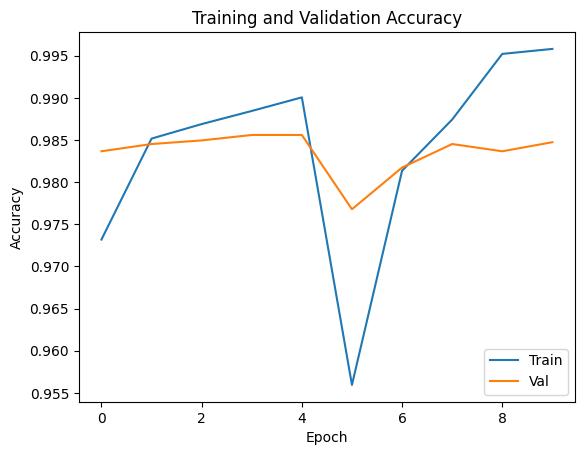

In [5]:
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'])
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()